In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt

%load_ext rpy2.ipython
import pandas as pd
import numpy as np

import os
os.chdir("/Users/lucapozzi/repos/Arlem/")

## Generate Data

In [4]:
from harlem.data.data_generator import DataGeneratorHarlem

In [5]:
%%capture
data_gen = DataGeneratorHarlem()

In [6]:
# [1] -0.36068676  0.01080478
data_gen.theta

array([-0.35714169,  0.0106924 ])

In [10]:
full_data, _ = data_gen.data_generator(5000)

seed: 1544399876


## Initialization

In [7]:
n_grid=300
tau = 100
x_grid = np.linspace(0, tau, num=n_grid)
v_grid = np.linspace(0, tau, num=n_grid)

In [11]:
delta_star = max(np.abs(np.diff(sorted(full_data.w))))
print(delta_star)

1.049932106443876


In [12]:
(full_data.w < full_data.v).mean()

1.0

In [13]:
from harlem.parameters.init_Q import init_Q

In [14]:
%%time
# Normalization Constant: [1] 1.178421
Q0 = init_Q(full_data, x_grid, v_grid, delta_star, tau=tau, verbose=True)
Q1, Q2 = Q0

h Opt [3.10823638 1.21235039]
Renormalization Constant: 0.9482545185578434
CPU times: user 52.9 s, sys: 267 ms, total: 53.2 s
Wall time: 54 s


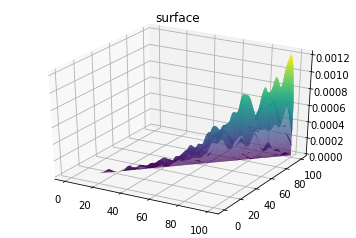

In [15]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, v_grid, Q2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');


In [200]:
(Q2==0).mean()

0.6404

In [201]:
%R mean(Q2==0)

array([0.84743333])

In [176]:
%R which(Q2!=0, arr.ind=TRUE)

array([[252,  20],
       [253,  20],
       [254,  20],
       ...,
       [270, 217],
       [236, 218],
       [271, 218]], dtype=int32)

In [16]:
from harlem.parameters.init_T import init_T

In [17]:
%%time
T0 = init_T(full_data, Q1['Qc'], Q1['dGn'], delta_star, x_grid, v_grid)
T1, T2 = T0

0.0 0.0033333333333333335 0.006666666666666667 0.01 0.013333333333333334 0.016666666666666666 0.02 0.023333333333333334 0.02666666666666667 0.03 0.03333333333333333 0.03666666666666667 0.04 0.043333333333333335 0.04666666666666667 0.05 0.05333333333333334 0.056666666666666664 0.06 0.06333333333333334 0.06666666666666667 0.07 0.07333333333333333 0.07666666666666666 0.08 0.08333333333333333 0.08666666666666667 0.09 0.09333333333333334 0.09666666666666666 0.1 0.10333333333333333 0.10666666666666667 0.11 0.11333333333333333 0.11666666666666667 0.12 0.12333333333333334 0.12666666666666668 0.13 0.13333333333333333 0.13666666666666666 0.14 0.14333333333333334 0.14666666666666667 0.15 0.15333333333333332 0.15666666666666668 0.16 0.16333333333333333 0.16666666666666666 0.17 0.17333333333333334 0.17666666666666667 0.18 0.18333333333333332 0.18666666666666668 0.19 0.19333333333333333 0.19666666666666666 0.2 0.20333333333333334 0.20666666666666667 0.21 0.21333333333333335 0.21666666666666667 0.22 

In [18]:
print((T1==0).mean(), (T1!=0).sum())
print((T2==0).mean(), (T2!=0).sum())

0.5116 43956
0.5116 43956


## Initial Estimator

In [19]:
%%capture
from harlem.estimator.linear_estimator import LinearEstimator

linear_estimator = LinearEstimator(full_data, T1, T2, Q1,
                                   x_grid, v_grid, delta_star)
theta_linear = linear_estimator.psi(Q2)

In [20]:
theta_linear

array([-0.38289231,  0.00829182])

In [123]:
%%R -i T1 -i T2 -i Q2
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(t(T1),t(T2),Q1,t(Q2),lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.47601067  0.01082111


In [49]:
%%R 
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(T0[[1]],T0[[2]],Q1,Q0[[2]],lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.460671440  0.009766997


In [40]:
data_gen.theta

array([-0.35714169,  0.0106924 ])

In [124]:
%%capture
from harlem.estimator.constant_estimator import ConstantEstimator

constant_estimator = ConstantEstimator(full_data, T1, T2, Q1,
                                   x_grid, v_grid, delta_star)
theta_constant = constant_estimator.psi(Q2)

In [125]:
theta_constant

-0.041061446148975236

## Debias

In [576]:
%%capture
from harlem.estimator.debias.tmle import HarlemTMLE
tmle = HarlemTMLE(full_data=full_data, delta_star=delta_star, Q0=Q0, T0=T0 verbose=True)


In [ ]:
tmle.fit()

In [139]:
Q2.shape

(300, 300)

In [140]:
%%capture
from harlem.estimator.debias.one_step import HarlemOneStep
one_step = HarlemOneStep(full_data=full_data, delta_star=delta_star, T0=(T1, T2), Q0=Q0)

In [141]:
one_step.fit()

array([[-0.47519389,  0.01085331],
       [-0.47519389,  0.01085331]])

## Test vs. R

In [19]:
%%R -i full_data

library("HARLEM")
library("splines")

lambdaConst <- function(tau){
    function(x){
        if(x<10)return(0)
        if(x>70)return(0)
        return(1)
    }
}
lambdaConst <- Vectorize(lambdaConst(tau))


dataGen <- dataGenHARLEM(delta=3, 100, lambda=lambdaConst,rate=0.017)
truth <- dataGen$theta
print(truth)

truth <- dataGen$theta
lambda <- dataGen$lambda
nGrid <- 300

tau <- 100

xGrid <- seq(0,tau,length.out=nGrid)
vGrid <- seq(0,tau,length.out=nGrid)


deltaStar <- max(diff(sort(full_data$w)))
print(deltaStar)

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: copula

  warnings.warn(x, RRuntimeWarning)


[1] -0.36068676  0.01080478
[1] 1.633118


In [20]:
data_gen.theta

array([-0.35714169,  0.0106924 ])

In [21]:
delta_star

1.6331175178268893

In [22]:
%%R
#source("~/repos/HARLEM/R/initFun.R")
cat("Initializing the Q's...\n")
Q0 <- initQ(full_data,xGrid,vGrid, deltaStar,tau=tau, verbose=TRUE); Q1 <- Q0[[1]]; Q2 <- Q0[[2]]
Sn <- Q1$Sn; Qc <- Q1$Qc; dGn <- Q1$dGn
hOpt <- attr(Q2,"hOpt")

Initializing the Q's...
a= -4.786507  b= 4.470215 
c= 0.4730105  d= 4.586132 

****
h Opt.[1] 0.09905883 0.05000000


In [81]:
print(Q1['Sn'](50))
print(Q1['dGn'][:5])
print(Q1['Qc'](60))

0.4979831054737309
[0.00026144 0.00016595 0.00016858 0.00013877 0.00013257]
0.29821775416894086


In [82]:
%%R
print(Q0[[1]]$Sn(50))
print(Q0[[1]]$dGn[1:5])
print(Q0[[1]]$Qc(60))

[1] 0.4979831
[1] 0.0002614159 0.0001659294 0.0001685629 0.0001387604 0.0001325616
[1] 0.2982178


In [268]:
%R hOpt

array([0.06571041, 0.05      ])

In [25]:
%%R
cat("Initializing the T's...\n")
T0 <- initT(full_data,Qc,dGn,deltaStar,xGrid,vGrid); T1 <- T0[[1]]; T2 <- T0[[2]]

Initializing the T's...


In [36]:
%R Q0[['Q2']]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
%R mean(Q0[['Q2']] == 0)

array([0.84104444])

In [39]:
%R Q0[['Q2']][Q0[['Q2']] != 0]

array([3.18768440e-05, 6.82571093e-05, 9.85827789e-05, ...,
       1.53537350e-04, 1.07037370e-04, 5.43215296e-05])

In [84]:
Q2[Q2!=0]

array([4.73341746e-15, 2.46368715e-13, 8.02959269e-12, ...,
       3.50447149e-09, 1.15388466e-09, 4.67606418e-10])

In [240]:
T1

array([[  0.        ,   0.        ,   0.        , ..., 165.22418146,
        166.5508776 , 167.91479202],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [142]:
%%R -i T1
print(mean(sort(T0[['T1']]) - sort(T1)))
print(max(sort(T0[['T1']]) - sort(T1)))

[1] 0.004981133
[1] 0.02337435


In [143]:
%%R -i T2
print(mean(sort(T0[['T2']]) - sort(T2)))
print(max(sort(T0[['T2']]) - sort(T2)))

[1] 0.0003070163
[1] 0.01164822


In [147]:
%%R
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(T0[[1]],T0[[2]],Q1,Q0[[2]],lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.460671440  0.009766997


In [273]:
theta_linear

array([ 4.04884828, -0.01710975])

In [144]:
%%R
cat("Running One Step...\n")
one_step <- harlem1Step(full_data,linearPsi(full_data,deltaStar,tau),deltaStar,tau,nGrid,
                        lambda=Vectorize(function(x)1*((x>=10)&(x<=70))),
                        Q0=Q0,T0=T0)

Running One Step...


In [145]:
%R one_step

array([[-0.46394313],
       [ 0.00909241]])

In [ ]:
%%R
cat("Running TMLE...\n")
TMLE <- harlemTMLE(full_data,stepLinear(full_data, deltaStar,tau,lambdaConst,1/sqrt(nrow(obsData))),
                   linearPsi(full_data,deltaStar,tau), deltaStar,tau,nGrid=nGrid, Q0=Q0,T0=T0)

In [1]:
%R names(TMLE)

UsageError: Line magic function `%R` not found.


In [2]:
%R TMLE[['Q2']]

UsageError: Line magic function `%R` not found.


In [277]:
%R TMLE[['thetaHat']]

array([[-0.52126093, -1.00357283],
       [ 0.01160983,  0.02329393]])

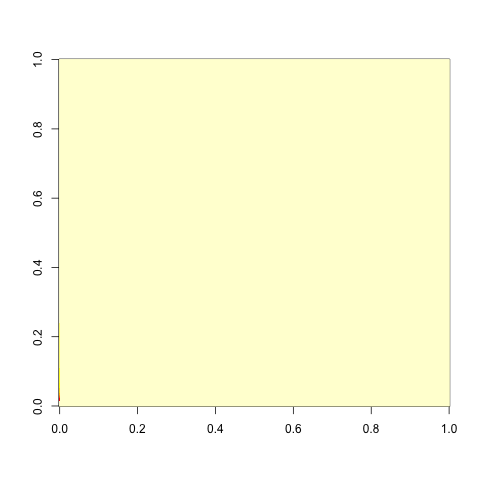

In [148]:
%%R
image(t(T0[[1]]) - T1)

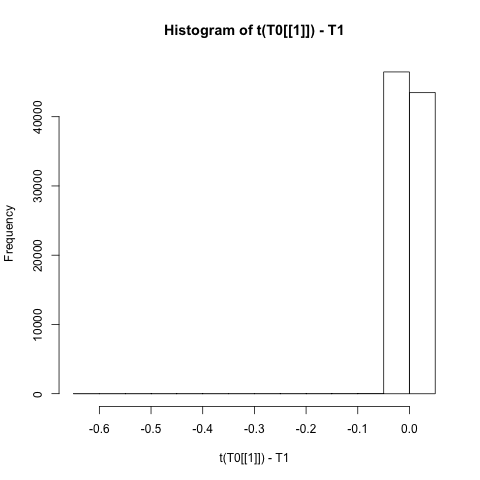

In [149]:
%%R
hist(t(T0[[1]]) - T1)

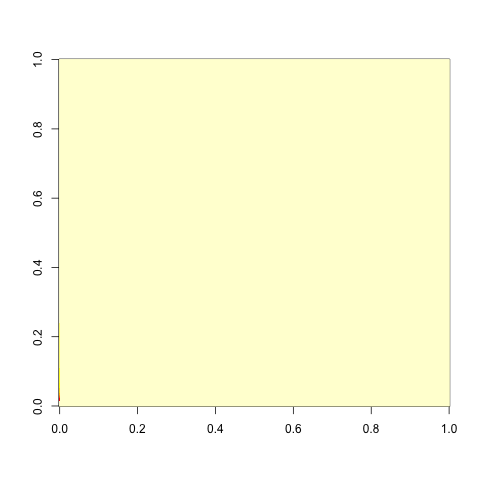

In [150]:
%%R
image(t(T0[[1]]) - T1)

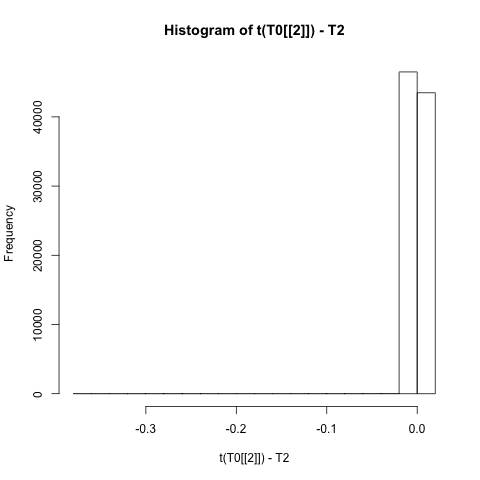

In [151]:
%%R
hist(t(T0[[2]]) - T2)

## TODOS

- test survival functions vs. `R`
- 